In [1]:
# %pip install -r ../requirements.txt

In [2]:
# CUDA 12.1 DOWNLOAD
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [3]:
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
import dill
import joblib

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [5]:
os.environ['TRANSFORMERS_CACHE'] = './models/cache'
os.environ['HF_HOME'] = './models/cache'

In [6]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, cohen_kappa_score, r2_score
from sentence_transformers import SentenceTransformer

e:\SEMESTER 6\NLP\UAS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\SEMESTER 6\NLP\UAS\.venv\Lib\site-packages\transformers\utils\hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import optuna

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
#comment if do not want to use cuda
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [11]:
nltk.data.path.append(os.path.abspath('nltk_data'))

In [12]:

# nltk.download('punkt_tab', download_dir='nltk_data')
# nltk.download('omw-1.4', download_dir='nltk_data')
# nltk.download('stopwords' , download_dir='nltk_data')
# nltk.download('wordnet' , download_dir='nltk_data')
# nltk.download('averaged_perceptron_tagger_eng' , download_dir='nltk_data')

---


In [13]:
dataset_path = os.path.abspath('../Dataset/dataset mamasmasmudi.xlsx')

In [14]:
def load_data(dataset_path):
    df_dpk_tkj = pd.read_excel(dataset_path, sheet_name='DPK (TKJ)')
    df_mpp_rpl = pd.read_excel(dataset_path, sheet_name='MPP (RPL)')
    df_mpp_ppl = pd.read_excel(dataset_path, sheet_name='MPP (PPL) 2')
    df_mpp_tkj = pd.read_excel(dataset_path, sheet_name='MPP (TKJ-Telkom)')
    df_kunci_jawaban = pd.read_excel(dataset_path, sheet_name='Kunci Jawaban')
    
    df = pd.concat([df_dpk_tkj, df_mpp_rpl, df_mpp_ppl, df_mpp_tkj])
    
    return df, df_kunci_jawaban

In [15]:
essays, jawaban_essay = load_data(dataset_path)

In [16]:
essays

,Kelas,Jurusan,Mapel,Nama,Pertanyaan,Kode,Jawaban,Nilai
0,X,TKJ,DPK,Zainur Ridho,Sebutkan 1 bisnis komputer yang anda ingin ban...,1,Berikut adalah contoh bisnis di bidang teknik ...,1.0
1,X,TKJ,DPK,Zainur Ridho,Sebutkan 5 dampak negatif perkembangan teknolo...,2,Pencemaran limbah dan bahan berbahaya\nMeningk...,2.0
2,X,TKJ,DPK,Zainur Ridho,Sebutkan 3 ciri-ciri dari jaringan seluler gen...,3,3G-Digital broadband packet data (CDMA EV-DO U...,2.0
3,X,TKJ,DPK,Zainur Ridho,Sebutkan dan jelaskan 3 hardware komputer yang...,4,Fungsi hardware menerima output\nFungsi hardwa...,2.3
4,X,TKJ,DPK,Uswatun Hasanah,Sebutkan 1 bisnis komputer yang anda ingin ban...,1,Jual beli komputer dan aksesorisnya yaitu menj...,3.0
...,...,...,...,...,...,...,...,...
159,XI,TKJ,MPP,Agus Arifin,"Jelaskan fungsi dan sensor LDR, Infrared, dan ...",10,LDR digunakan untuk kontrol lampu di taman\nIn...,2.5
160,XI,TKJ,MPP,Agus Arifin,Jelaskan Jenis Arduino yang paling mudah dipel...,11,Arduino uno karena banyak sekali reserensi yan...,2.0
161,XI,TKJ,MPP,Agus Arifin,"Jelaskan fungsi dari kabel jumper, breadboard ...",12,Kabel jumper = sbg konduktor listrik\nbreadboa...,3.0
162,XI,TKJ,MPP,Agus Arifin,Proyek sederhana yang dapat dimanfaatkan dalam...,13,Colokan listrik pintar\nPenerapan IOT pada tem...,2.5


In [17]:
jawaban_essay

,Kode,jurusan,Kelas,Mata Pelajaran,Pertanyaan,Jawaban
0,1,TKJ,X,DPK,Sebutkan 1 bisnis komputer yang anda ingin ban...,Bisnis Komputer yang Ingin Saya Bangun:\nBisni...
1,2,TKJ,X,DPK,Sebutkan 5 dampak negatif perkembangan teknolo...,5 Dampak Negatif Perkembangan Teknologi:\nKete...
2,3,TKJ,X,DPK,Sebutkan 3 ciri-ciri dari jaringan seluler gen...,3 Ciri-ciri Jaringan Seluler Generasi 3 (3G):\...
3,4,TKJ,X,DPK,Sebutkan dan jelaskan 3 hardware komputer yang...,3 Hardware Komputer dan Penjelasan:\nCPU (Cent...
4,5,RPL,XI,MPP,Jelaskan ancaman keamanan yang mungkin terjadi...,Ancaman Keamanan Mengunduh Driver Perangkat Ke...
5,6,RPL,XI,MPP,Jelaskan proses langkah-langkah menyalakan dan...,Menyalakan Komputer:\n\nPastikan semua kabel p...
6,7,RPL,XI,MPP,Jelaskan pengertian sistem operasi (SO) dan se...,Sistem operasi (SO) adalah perangkat lunak sis...
7,8,RPL,XI,MPP,Bagaimana perbedaan antara perangkat keras (ha...,Perangkat keras (hardware) adalah komponen fis...
8,9,RPL,XI,MPP,Jelaskan perbedaan utama antara bus internal d...,Bus internal:\nJalur komunikasi yang menghubun...
9,10,TKJ,XI,MPP,"Jelaskan fungsi dan sensor LDR, Infrared, dan ...",1. LDR (Light Dependent Resistor):\nFungsi: Se...


In [18]:
essays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 519 entries, 0 to 163
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Kelas       519 non-null    object 
 1   Jurusan     519 non-null    object 
 2   Mapel       519 non-null    object 
 3   Nama        519 non-null    object 
 4   Pertanyaan  519 non-null    object 
 5   Kode        519 non-null    int64  
 6   Jawaban     519 non-null    object 
 7   Nilai       519 non-null    float64
dtypes: float64(1), int64(1), object(6)
memory usage: 36.5+ KB


In [19]:
jawaban_essay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Kode            14 non-null     int64 
 1   jurusan         14 non-null     object
 2   Kelas           14 non-null     object
 3   Mata Pelajaran  14 non-null     object
 4   Pertanyaan      14 non-null     object
 5   Jawaban         14 non-null     object
dtypes: int64(1), object(5)
memory usage: 804.0+ bytes


In [20]:
essays.describe()

,Kode,Nilai
count,519.000000,519.000000
mean,7.815029,2.769942
std,3.533142,0.902924
min,1.000000,0.000000
25%,5.000000,2.500000
50%,8.000000,3.000000
75%,11.000000,3.000000
max,14.000000,4.000000


In [21]:
essays['Nilai'].unique()

array([1. , 2. , 2.3, 3. , 4. , 2.5, 2.2, 2.1, 3.1, 0.1, 3.5, 1.5, 2.7,
       3.8, 3.2, 2.8, 2.9, 0. ])

---


# Preprocess


In [22]:

class EssayPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('indonesian'))
        self.sbert = SentenceTransformer('firqaaa/indo-sentence-bert-base',
                                            device="cuda" if torch.cuda.is_available() else "cpu")

    def preprocess_text(self, text):
        if not text:
            return ""
        text = text.lower()
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s]', '', text)
        # text = re.sub(r'\d+', '', text) 

        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stop_words]
        return ' '.join(tokens)

    def extract_linguistic_features(self, text):
        if not text:
            return {}

        words = word_tokenize(text)
        unique_words = set(words)
        vocab_richness = len(unique_words) / max(1, len(words))

        sentences = sent_tokenize(text)
        avg_sentence_len = sum(len(word_tokenize(s)) for s in sentences) / max(1, len(sentences))


        return {
            'vocab_richness': vocab_richness,
            'avg_sentence_len': avg_sentence_len,
            'total_words': len(words),

        }
        

    def minmaxnormalize_nilai(self, nilai):
        if not isinstance(nilai, (int, float)):
            return 0.0
        min_val = 0
        max_val = 4
        normalized_nilai = (nilai - min_val) / (max_val - min_val)
        return normalized_nilai
    
    def get_sbert_embedding(self, text):
        return self.sbert.encode(text, show_progress_bar=False)

    def __getstate__(self):
        state = self.__dict__.copy()
        del state['sbert']
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        self.sbert = SentenceTransformer('firqaaa/indo-sentence-bert-base',
                                            device="cuda" if torch.cuda.is_available() else "cpu")


In [23]:
preprocessor = EssayPreprocessor()

In [24]:
essays['processed_text'] = essays['Jawaban'].apply(preprocessor.preprocess_text)
essays['Nilai'] = essays['Nilai'].apply(preprocessor.minmaxnormalize_nilai)
jawaban_essay['processed_kunci_jawaban'] = jawaban_essay['Jawaban'].apply(preprocessor.preprocess_text)



In [25]:
essays

,Kelas,Jurusan,Mapel,Nama,Pertanyaan,Kode,Jawaban,Nilai,processed_text
0,X,TKJ,DPK,Zainur Ridho,Sebutkan 1 bisnis komputer yang anda ingin ban...,1,Berikut adalah contoh bisnis di bidang teknik ...,0.250,contoh bisnis bidang teknik komputer jaringan ...
1,X,TKJ,DPK,Zainur Ridho,Sebutkan 5 dampak negatif perkembangan teknolo...,2,Pencemaran limbah dan bahan berbahaya\nMeningk...,0.500,pencemaran limbah bahan berbahaya meningkatnya...
2,X,TKJ,DPK,Zainur Ridho,Sebutkan 3 ciri-ciri dari jaringan seluler gen...,3,3G-Digital broadband packet data (CDMA EV-DO U...,0.500,3gdigital broadband packet data cdma evdo umts...
3,X,TKJ,DPK,Zainur Ridho,Sebutkan dan jelaskan 3 hardware komputer yang...,4,Fungsi hardware menerima output\nFungsi hardwa...,0.575,fungsi hardware menerima output fungsi hardwar...
4,X,TKJ,DPK,Uswatun Hasanah,Sebutkan 1 bisnis komputer yang anda ingin ban...,1,Jual beli komputer dan aksesorisnya yaitu menj...,0.750,jual beli komputer aksesorisnya menjual laptop...
...,...,...,...,...,...,...,...,...,...
159,XI,TKJ,MPP,Agus Arifin,"Jelaskan fungsi dan sensor LDR, Infrared, dan ...",10,LDR digunakan untuk kontrol lampu di taman\nIn...,0.625,ldr kontrol lampu taman infrared penciptaan pa...
160,XI,TKJ,MPP,Agus Arifin,Jelaskan Jenis Arduino yang paling mudah dipel...,11,Arduino uno karena banyak sekali reserensi yan...,0.500,arduino uno reserensi membahas arduino uno
161,XI,TKJ,MPP,Agus Arifin,"Jelaskan fungsi dari kabel jumper, breadboard ...",12,Kabel jumper = sbg konduktor listrik\nbreadboa...,0.750,kabel jumper sbg konduktor listrik breadboard ...
162,XI,TKJ,MPP,Agus Arifin,Proyek sederhana yang dapat dimanfaatkan dalam...,13,Colokan listrik pintar\nPenerapan IOT pada tem...,0.625,colokan listrik pintar penerapan iot sampah al...


In [26]:
essays['Nilai'].unique()

array([0.25 , 0.5  , 0.575, 0.75 , 1.   , 0.625, 0.55 , 0.525, 0.775,
       0.025, 0.875, 0.375, 0.675, 0.95 , 0.8  , 0.7  , 0.725, 0.   ])

In [27]:
jawaban_essay

,Kode,jurusan,Kelas,Mata Pelajaran,Pertanyaan,Jawaban,processed_kunci_jawaban
0,1,TKJ,X,DPK,Sebutkan 1 bisnis komputer yang anda ingin ban...,Bisnis Komputer yang Ingin Saya Bangun:\nBisni...,bisnis komputer bangun bisnis jasa pembuatan p...
1,2,TKJ,X,DPK,Sebutkan 5 dampak negatif perkembangan teknolo...,5 Dampak Negatif Perkembangan Teknologi:\nKete...,5 dampak negatif perkembangan teknologi keterg...
2,3,TKJ,X,DPK,Sebutkan 3 ciri-ciri dari jaringan seluler gen...,3 Ciri-ciri Jaringan Seluler Generasi 3 (3G):\...,3 ciriciri jaringan seluler generasi 3 3g kece...
3,4,TKJ,X,DPK,Sebutkan dan jelaskan 3 hardware komputer yang...,3 Hardware Komputer dan Penjelasan:\nCPU (Cent...,3 hardware komputer penjelasan cpu central pro...
4,5,RPL,XI,MPP,Jelaskan ancaman keamanan yang mungkin terjadi...,Ancaman Keamanan Mengunduh Driver Perangkat Ke...,ancaman keamanan mengunduh driver perangkat ke...
5,6,RPL,XI,MPP,Jelaskan proses langkah-langkah menyalakan dan...,Menyalakan Komputer:\n\nPastikan semua kabel p...,menyalakan komputer pastikan kabel power terpa...
6,7,RPL,XI,MPP,Jelaskan pengertian sistem operasi (SO) dan se...,Sistem operasi (SO) adalah perangkat lunak sis...,sistem operasi so perangkat lunak sistem menge...
7,8,RPL,XI,MPP,Bagaimana perbedaan antara perangkat keras (ha...,Perangkat keras (hardware) adalah komponen fis...,perangkat keras hardware komponen fisik komput...
8,9,RPL,XI,MPP,Jelaskan perbedaan utama antara bus internal d...,Bus internal:\nJalur komunikasi yang menghubun...,bus internal jalur komunikasi menghubungkan ko...
9,10,TKJ,XI,MPP,"Jelaskan fungsi dan sensor LDR, Infrared, dan ...",1. LDR (Light Dependent Resistor):\nFungsi: Se...,1 ldr light dependent resistor fungsi sensor c...


In [28]:
linguistic_features = essays['processed_text'].apply(preprocessor.extract_linguistic_features)
linguistic_features_kunci_jawaban = jawaban_essay['processed_kunci_jawaban'].apply(preprocessor.extract_linguistic_features)
linguistic_df =  pd.json_normalize(linguistic_features)
linguistic_df_kunci_jawaban =  pd.json_normalize(linguistic_features_kunci_jawaban)

In [29]:
linguistic_df

,vocab_richness,avg_sentence_len,total_words
0,0.846154,13.0,13
1,0.950000,20.0,20
2,1.000000,8.0,8
3,0.692308,13.0,13
4,0.866667,15.0,15
...,...,...,...
514,1.000000,13.0,13
515,0.666667,6.0,6
516,1.000000,15.0,15
517,1.000000,9.0,9


In [30]:
linguistic_features_kunci_jawaban

0     {'vocab_richness': 0.7272727272727273, 'avg_se...
1     {'vocab_richness': 0.8431372549019608, 'avg_se...
2     {'vocab_richness': 0.6129032258064516, 'avg_se...
3     {'vocab_richness': 0.6610169491525424, 'avg_se...
4     {'vocab_richness': 0.6568627450980392, 'avg_se...
5     {'vocab_richness': 0.6545454545454545, 'avg_se...
6     {'vocab_richness': 0.5327102803738317, 'avg_se...
7     {'vocab_richness': 0.6320754716981132, 'avg_se...
8     {'vocab_richness': 0.578125, 'avg_sentence_len...
9     {'vocab_richness': 0.6901408450704225, 'avg_se...
10    {'vocab_richness': 0.4925373134328358, 'avg_se...
11    {'vocab_richness': 0.4019607843137255, 'avg_se...
12    {'vocab_richness': 0.5853658536585366, 'avg_se...
13    {'vocab_richness': 0.6046511627906976, 'avg_se...
Name: processed_kunci_jawaban, dtype: object

In [31]:
df_merged = pd.merge(essays, jawaban_essay,on="Kode")
df_merged = df_merged.rename(columns={'Pertanyaan_x': 'Pertanyaan', 'Jawaban_x': 'Jawaban siswa' , 'Jawaban_y': 'Kunci Jawaban'})


In [32]:
df_merged = df_merged.drop(columns=['Pertanyaan_y', 'Nama', 'Kelas_x', 'Kelas_y', 'jurusan', 'Mata Pelajaran'])

In [33]:
df_merged

,Jurusan,Mapel,Pertanyaan,Kode,Jawaban siswa,Nilai,processed_text,Kunci Jawaban,processed_kunci_jawaban
0,TKJ,DPK,Sebutkan 1 bisnis komputer yang anda ingin ban...,1,Berikut adalah contoh bisnis di bidang teknik ...,0.250,contoh bisnis bidang teknik komputer jaringan ...,Bisnis Komputer yang Ingin Saya Bangun:\nBisni...,bisnis komputer bangun bisnis jasa pembuatan p...
1,TKJ,DPK,Sebutkan 5 dampak negatif perkembangan teknolo...,2,Pencemaran limbah dan bahan berbahaya\nMeningk...,0.500,pencemaran limbah bahan berbahaya meningkatnya...,5 Dampak Negatif Perkembangan Teknologi:\nKete...,5 dampak negatif perkembangan teknologi keterg...
2,TKJ,DPK,Sebutkan 3 ciri-ciri dari jaringan seluler gen...,3,3G-Digital broadband packet data (CDMA EV-DO U...,0.500,3gdigital broadband packet data cdma evdo umts...,3 Ciri-ciri Jaringan Seluler Generasi 3 (3G):\...,3 ciriciri jaringan seluler generasi 3 3g kece...
3,TKJ,DPK,Sebutkan dan jelaskan 3 hardware komputer yang...,4,Fungsi hardware menerima output\nFungsi hardwa...,0.575,fungsi hardware menerima output fungsi hardwar...,3 Hardware Komputer dan Penjelasan:\nCPU (Cent...,3 hardware komputer penjelasan cpu central pro...
4,TKJ,DPK,Sebutkan 1 bisnis komputer yang anda ingin ban...,1,Jual beli komputer dan aksesorisnya yaitu menj...,0.750,jual beli komputer aksesorisnya menjual laptop...,Bisnis Komputer yang Ingin Saya Bangun:\nBisni...,bisnis komputer bangun bisnis jasa pembuatan p...
...,...,...,...,...,...,...,...,...,...
514,TKJ,MPP,"Jelaskan fungsi dan sensor LDR, Infrared, dan ...",10,LDR digunakan untuk kontrol lampu di taman\nIn...,0.625,ldr kontrol lampu taman infrared penciptaan pa...,1. LDR (Light Dependent Resistor):\nFungsi: Se...,1 ldr light dependent resistor fungsi sensor c...
515,TKJ,MPP,Jelaskan Jenis Arduino yang paling mudah dipel...,11,Arduino uno karena banyak sekali reserensi yan...,0.500,arduino uno reserensi membahas arduino uno,Jenis Arduino yang paling mudah dipelajari ole...,jenis arduino mudah dipelajari pemula arduino ...
516,TKJ,MPP,"Jelaskan fungsi dari kabel jumper, breadboard ...",12,Kabel jumper = sbg konduktor listrik\nbreadboa...,0.750,kabel jumper sbg konduktor listrik breadboard ...,1. Kabel Jumper:\nFungsi: Menghubungkan pin Ar...,1 kabel jumper fungsi menghubungkan pin arduin...
517,TKJ,MPP,Proyek sederhana yang dapat dimanfaatkan dalam...,13,Colokan listrik pintar\nPenerapan IOT pada tem...,0.625,colokan listrik pintar penerapan iot sampah al...,3 Proyek Arduino Sederhana untuk Kehidupan Seh...,3 proyek arduino sederhana kehidupan seharihar...


In [34]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Jurusan                  519 non-null    object 
 1   Mapel                    519 non-null    object 
 2   Pertanyaan               519 non-null    object 
 3   Kode                     519 non-null    int64  
 4   Jawaban siswa            519 non-null    object 
 5   Nilai                    519 non-null    float64
 6   processed_text           519 non-null    object 
 7   Kunci Jawaban            519 non-null    object 
 8   processed_kunci_jawaban  519 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 36.6+ KB


In [35]:
print("Generating SBERT embeddings...")
jawaban_embeddings = np.array(essays['processed_text'].apply(preprocessor.get_sbert_embedding).tolist())
sbert_df_jawaban_siswa = pd.DataFrame(jawaban_embeddings)
kunci_embeddings = np.array(jawaban_essay['processed_kunci_jawaban'].apply(preprocessor.get_sbert_embedding).tolist())
sbert_df_kunci_jawaban = pd.DataFrame(kunci_embeddings)

Generating SBERT embeddings...


In [36]:
sbert_df_jawaban_siswa

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.175030,-0.100799,1.682354,-0.216196,0.592488,-1.517554,-0.489747,0.765023,0.310957,-0.178229,...,-0.420064,1.277779,-0.940241,-0.645339,0.557744,-1.005366,-0.391045,0.055750,0.169516,-0.967723
1,0.302545,0.030771,0.230476,0.382820,-0.523025,0.330591,-0.693463,-0.166704,-1.380329,0.214211,...,-0.510979,-1.792203,1.211305,-0.698730,-0.047026,-1.341776,-0.636428,0.102431,0.306777,-0.876139
2,-0.107437,-0.164470,1.923192,0.519176,0.451790,-1.203257,-0.415526,0.231506,0.036357,-0.549033,...,-0.101170,-0.833894,0.266178,0.452516,-0.438673,-0.381386,-0.188773,0.812278,-0.270655,-0.946806
3,-1.286455,-0.111820,0.128265,-0.454459,-0.965123,-0.351172,0.972212,-0.392952,-0.897284,-0.518873,...,-0.510029,1.048704,-1.305567,-1.689827,0.684887,-0.061914,-0.200106,0.207169,-0.535120,0.054254
4,-1.043335,-0.003052,1.315789,-0.058243,-1.282312,-0.995101,0.236723,0.671957,0.115669,-0.360998,...,-0.363974,1.146494,-1.441932,-0.501645,-0.103334,-0.155018,0.178085,-0.437461,0.355227,-0.522968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,-0.698083,0.275296,0.290783,0.971196,-0.352881,0.543560,-0.975893,1.057699,0.014698,-0.433743,...,-0.078026,-0.677586,1.552675,-0.024974,-1.956708,1.044516,0.366149,-0.173939,0.147613,-0.426446
515,1.672262,-0.610270,0.937194,0.454997,0.107848,-0.746585,-0.405437,-0.328618,0.095163,0.250383,...,-0.521903,-0.149402,0.911688,-0.135366,1.038370,1.453146,0.404324,-1.760466,0.296292,-0.124616
516,-1.005741,-0.649992,0.761631,0.834240,-0.522514,1.054761,0.431271,0.388890,0.523791,-0.287212,...,-0.366015,0.623573,-0.978789,-0.983525,0.247386,-0.871403,0.105388,-1.058236,-0.185371,-0.767394
517,-1.777034,-0.076182,0.048817,-0.440416,-0.181754,1.621295,-0.425587,0.216549,0.305719,-1.673116,...,-0.102800,-0.205169,0.115081,-1.475819,-1.502191,-1.592802,1.336190,-0.884481,-0.622243,-0.695940


In [37]:
sbert_df_kunci_jawaban

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.044179,1.520241,0.356794,-1.246257,-0.804146,-0.856998,-0.043271,0.961092,-0.061612,0.105452,...,0.012635,0.679246,0.283080,-0.176213,-0.073303,0.094545,-0.327470,-0.348405,0.671513,0.178814
1,0.140464,0.508892,-0.241081,-0.327461,-1.408649,-0.051619,-1.099225,0.692906,0.276846,0.557357,...,0.043388,0.406179,-0.262345,0.147805,0.818970,0.353148,0.732627,0.927354,0.624377,0.383790
2,0.223004,0.341609,0.778978,-0.383603,-0.385628,-0.347250,-0.185442,0.524693,0.023808,0.100843,...,0.830399,-0.594608,0.827541,-0.279250,0.282690,0.087055,-0.439376,0.554189,-1.360345,-0.659503
3,0.322104,-0.263320,0.756519,-0.127722,-0.236260,-1.569635,0.037740,0.842755,0.399926,-0.352552,...,0.305312,0.243610,0.701350,-1.083380,0.726323,0.153706,-0.423909,-0.261539,-0.314057,-0.297754
4,-0.323143,1.247857,-0.412609,-2.201902,-0.161218,-0.473667,-0.274465,0.747822,-0.172206,-0.098101,...,0.653038,-0.060995,0.195506,-0.483997,0.753308,-1.631002,1.130888,-0.369363,-1.300190,-0.330897
5,-0.640675,-0.795983,0.206095,-0.267124,-0.757647,-0.532407,-0.767546,0.813864,0.502924,0.215119,...,0.701066,1.587010,-0.140611,-0.626866,-0.605606,1.066471,-0.007974,0.194956,-0.706504,-0.768348
6,-0.218142,-0.164077,0.691508,0.101299,-0.311363,-0.689958,-0.258895,0.946968,-0.286363,-0.865739,...,-0.277956,0.620673,-0.639076,-0.902595,0.363155,-0.350366,-0.756952,-0.192084,-0.665643,0.575894
7,-0.024973,-0.019298,0.801230,-0.705033,-0.342683,-1.354301,-0.162469,0.942443,-0.239914,-0.568882,...,0.502491,-0.012291,-0.035355,-0.922270,0.878009,-0.575592,-0.360076,0.056490,-0.572545,-0.359301
8,1.042357,-0.211008,-0.035648,-1.529719,0.367899,-0.939558,-0.351271,-0.093032,0.532376,0.450149,...,0.623414,0.767900,0.558323,0.241887,0.282559,0.565277,-1.092410,-1.424773,-0.674009,-0.194541
9,0.340520,0.214257,0.643329,-0.464276,0.095431,0.421940,-0.782009,-0.577028,-0.066430,0.392976,...,0.526891,-0.043135,0.760848,-0.596424,-0.626304,0.905681,-0.089782,-0.739246,-1.391205,-1.163314


In [38]:
sbert_linguistic = pd.concat([sbert_df_jawaban_siswa, linguistic_df], axis=1)
kunci_linguistic = pd.concat([sbert_df_kunci_jawaban, linguistic_df_kunci_jawaban], axis=1)

In [39]:
from scipy.spatial.distance import cosine
def calculate_similarity(row):
    student_emb = jawaban_embeddings[row.name]
    key_emb = kunci_embeddings[row['Kode'] - 1]  # Asumsi Kode dimulai dari 1
    return 1 - cosine(student_emb, key_emb)

df_merged['semantic_similarity'] = df_merged.apply(calculate_similarity, axis=1)

X = pd.concat([sbert_linguistic, df_merged[['semantic_similarity']]], axis=1).values
y = df_merged['Nilai'].values

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, np.arange(len(X)), 
    test_size=0.2, 
    random_state=42, 
    stratify=df_merged['Kode']
)

In [40]:
X

array([[-0.17503035, -0.10079882,  1.68235397, ..., 13.        ,
        13.        ,  0.5597986 ],
       [ 0.30254525,  0.0307712 ,  0.23047628, ..., 20.        ,
        20.        ,  0.2192719 ],
       [-0.10743705, -0.16446973,  1.92319155, ...,  8.        ,
         8.        ,  0.68381828],
       ...,
       [-1.00574136, -0.64999193,  0.76163107, ..., 15.        ,
        15.        ,  0.68666053],
       [-1.77703357, -0.07618213,  0.0488173 , ...,  9.        ,
         9.        ,  0.41771531],
       [ 0.49302059,  0.77206415,  0.47420102, ...,  6.        ,
         6.        ,  0.57331789]], shape=(519, 772))

In [41]:
y

array([0.25 , 0.5  , 0.5  , 0.575, 0.75 , 1.   , 0.5  , 0.5  , 0.625,
       1.   , 1.   , 0.55 , 1.   , 0.525, 1.   , 0.5  , 1.   , 0.5  ,
       1.   , 1.   , 0.75 , 0.75 , 1.   , 1.   , 0.75 , 0.75 , 1.   ,
       0.55 , 0.5  , 1.   , 1.   , 0.75 , 1.   , 1.   , 1.   , 1.   ,
       0.525, 0.25 , 1.   , 0.5  , 0.5  , 1.   , 1.   , 1.   , 0.75 ,
       1.   , 0.5  , 1.   , 0.5  , 0.75 , 0.5  , 1.   , 1.   , 0.5  ,
       0.5  , 0.5  , 1.   , 1.   , 0.75 , 0.5  , 0.5  , 1.   , 0.5  ,
       0.5  , 0.775, 1.   , 0.5  , 1.   , 1.   , 1.   , 1.   , 0.25 ,
       0.25 , 1.   , 1.   , 0.25 , 0.25 , 1.   , 1.   , 0.5  , 0.575,
       1.   , 0.75 , 0.5  , 1.   , 1.   , 0.25 , 0.5  , 1.   , 0.5  ,
       1.   , 0.5  , 0.75 , 0.5  , 0.75 , 1.   , 0.75 , 1.   , 1.   ,
       1.   , 0.75 , 0.75 , 1.   , 0.5  , 0.5  , 1.   , 0.75 , 0.25 ,
       0.75 , 0.75 , 1.   , 0.75 , 1.   , 0.75 , 0.75 , 1.   , 0.75 ,
       0.75 , 1.   , 0.75 , 0.025, 0.25 , 0.75 , 1.   , 0.75 , 0.25 ,
       0.875, 0.75 ,

---


In [42]:
class AESModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=2, dropout=0.3):
        super(AESModel, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.sigmoid(self.output_layer(x)) * 4  # Scale to 0-4 range

In [43]:
# class AESModel(nn.Module):
#     def __init__(self, input_dim):
#         super(AESModel, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 256)
#         self.bn1 = nn.BatchNorm1d(256)
#         self.drop1 = nn.Dropout(0.4)
#         self.fc2 = nn.Linear(256, 128)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.drop2 = nn.Dropout(0.3)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc_out = nn.Linear(64, 1)
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.drop1(x)
#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.drop2(x)
#         x = self.fc3(x)
#         x = self.relu(x)
#         return self.fc_out(x)

In [44]:
def train_model(X_train, y_train, params, X_val=None, y_val=None):
    # Konversi ke tensor
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    
    # Inisialisasi model
    model = AESModel(
        input_dim=X_train.shape[1],
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(params['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.MSELoss()
    
    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    
    for epoch in range(params['epochs']):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(params['device']), batch_y.to(params['device'])
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        if X_val is not None:
            model.eval()
            with torch.no_grad():
                val_X = torch.FloatTensor(X_val).to(params['device'])
                val_y = torch.FloatTensor(y_val).to(params['device'])
                val_outputs = model(val_X)
                val_loss = criterion(val_outputs.squeeze(), val_y).item()
            
            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), './models/best_model.pt')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            print(f"Epoch {epoch+1}/{params['epochs']} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{params['epochs']} - Train Loss: {avg_train_loss:.4f}")
    
    # Load best model for validation
    if X_val is not None:
        model.load_state_dict(torch.load('./models/best_model.pt'))
    
    return model

In [45]:
def evaluate_model(model, X_test, y_test, device='cpu'):
    model.eval()
    with torch.no_grad():
        test_X = torch.FloatTensor(X_test).to(device)
        test_y = torch.FloatTensor(y_test).to(device)
        predictions = model(test_X).squeeze().cpu().numpy()
    
    # Hitung metrik evaluasi
    mse = mean_squared_error(y_test, predictions)
    qwk = cohen_kappa_score(
        (y_test * 4).round().astype(int), 
        (predictions * 4).round().astype(int), 
        weights='quadratic'
    )
    r2 = r2_score(y_test, predictions)
    
    print(f"\nEvaluation Results:")
    print(f"MSE: {mse:.4f}")
    print(f"QWK: {qwk:.4f}")
    print(f"R2 Score: {r2:.4f}")
    
    # Plot hasil
    plt.figure(figsize=(10, 6))
    sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':0.3})
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Actual vs Predicted Scores')
    plt.show()
    
    return {'mse': mse, 'qwk': qwk, 'r2': r2}

In [46]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'hidden_dim': trial.suggest_categorical('hidden_dim', [128, 256, 512]),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'epochs': 50,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }
    
    # Split validation set
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(
        X_train, y_train, test_size=0.2, random_state=trial.number)
    
    # Train model
    model = train_model(X_train_fold, y_train_fold, params, X_val_fold, y_val_fold)
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_X = torch.FloatTensor(X_val_fold).to(params['device'])
        val_y = torch.FloatTensor(y_val_fold).to(params['device'])
        val_outputs = model(val_X).squeeze().cpu().numpy()
    
    qwk = cohen_kappa_score(
        (val_y.cpu().numpy() * 4).round().astype(int), 
        (val_outputs * 4).round().astype(int), 
        weights='quadratic'
    )
    
    return qwk

In [47]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=1)

# Dapatkan parameter terbaik
best_params = study.best_params
best_params.update({
    'epochs': 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
})
print("\nBest Hyperparameters:", best_params)

[I 2025-05-09 19:51:33,163] A new study created in memory with name: no-name-9005ee2f-e5f6-4313-ba6b-6154b9e1a104


Epoch 1/50 - Train Loss: 1.2811 - Val Loss: 1.2040
Epoch 2/50 - Train Loss: 1.0105 - Val Loss: 0.9374
Epoch 3/50 - Train Loss: 0.7464 - Val Loss: 0.7191
Epoch 4/50 - Train Loss: 0.5701 - Val Loss: 0.5446
Epoch 5/50 - Train Loss: 0.4355 - Val Loss: 0.4122
Epoch 6/50 - Train Loss: 0.3343 - Val Loss: 0.3180
Epoch 7/50 - Train Loss: 0.2806 - Val Loss: 0.2534
Epoch 8/50 - Train Loss: 0.2152 - Val Loss: 0.2117
Epoch 9/50 - Train Loss: 0.1801 - Val Loss: 0.1863
Epoch 10/50 - Train Loss: 0.1687 - Val Loss: 0.1712
Epoch 11/50 - Train Loss: 0.1334 - Val Loss: 0.1611
Epoch 12/50 - Train Loss: 0.1440 - Val Loss: 0.1536
Epoch 13/50 - Train Loss: 0.1544 - Val Loss: 0.1472
Epoch 14/50 - Train Loss: 0.1421 - Val Loss: 0.1409
Epoch 15/50 - Train Loss: 0.1238 - Val Loss: 0.1354
Epoch 16/50 - Train Loss: 0.1175 - Val Loss: 0.1298
Epoch 17/50 - Train Loss: 0.1121 - Val Loss: 0.1245
Epoch 18/50 - Train Loss: 0.1075 - Val Loss: 0.1194
Epoch 19/50 - Train Loss: 0.1025 - Val Loss: 0.1146
Epoch 20/50 - Train L

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 48/50 - Train Loss: 0.0509 - Val Loss: 0.0495
Epoch 49/50 - Train Loss: 0.0478 - Val Loss: 0.0488
Epoch 50/50 - Train Loss: 0.0477 - Val Loss: 0.0479
Epoch 1/50 - Train Loss: 1.8920 - Val Loss: 1.7889
Epoch 2/50 - Train Loss: 1.7723 - Val Loss: 1.7050
Epoch 3/50 - Train Loss: 1.7026 - Val Loss: 1.6189
Epoch 4/50 - Train Loss: 1.6156 - Val Loss: 1.5289
Epoch 5/50 - Train Loss: 1.5062 - Val Loss: 1.4299
Epoch 6/50 - Train Loss: 1.4022 - Val Loss: 1.3214
Epoch 7/50 - Train Loss: 1.3161 - Val Loss: 1.2010
Epoch 8/50 - Train Loss: 1.1628 - Val Loss: 1.0679
Epoch 9/50 - Train Loss: 1.0370 - Val Loss: 0.9279
Epoch 10/50 - Train Loss: 0.9115 - Val Loss: 0.7833
Epoch 11/50 - Train Loss: 0.7725 - Val Loss: 0.6417
Epoch 12/50 - Train Loss: 0.6379 - Val Loss: 0.5106
Epoch 13/50 - Train Loss: 0.4938 - Val Loss: 0.3985
Epoch 14/50 - Train Loss: 0.3948 - Val Loss: 0.3094
Epoch 15/50 - Train Loss: 0.3099 - Val Loss: 0.2414
Epoch 16/50 - Train Loss: 0.2698 - Val Loss: 0.1927
Epoch 17/50 - Train L

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 49/50 - Train Loss: 0.0594 - Val Loss: 0.0445
Epoch 50/50 - Train Loss: 0.0596 - Val Loss: 0.0436
Epoch 1/50 - Train Loss: 1.0127 - Val Loss: 0.2891
Epoch 2/50 - Train Loss: 0.1797 - Val Loss: 0.1429
Epoch 3/50 - Train Loss: 0.1916 - Val Loss: 0.1577
Epoch 4/50 - Train Loss: 0.1346 - Val Loss: 0.0683
Epoch 5/50 - Train Loss: 0.0702 - Val Loss: 0.0727
Epoch 6/50 - Train Loss: 0.0755 - Val Loss: 0.0615
Epoch 7/50 - Train Loss: 0.0507 - Val Loss: 0.0390
Epoch 8/50 - Train Loss: 0.0462 - Val Loss: 0.0347
Epoch 9/50 - Train Loss: 0.0336 - Val Loss: 0.0348
Epoch 10/50 - Train Loss: 0.0264 - Val Loss: 0.0269
Epoch 11/50 - Train Loss: 0.0234 - Val Loss: 0.0213
Epoch 12/50 - Train Loss: 0.0206 - Val Loss: 0.0240
Epoch 13/50 - Train Loss: 0.0196 - Val Loss: 0.0191
Epoch 14/50 - Train Loss: 0.0144 - Val Loss: 0.0173
Epoch 15/50 - Train Loss: 0.0152 - Val Loss: 0.0207
Epoch 16/50 - Train Loss: 0.0151 - Val Loss: 0.0175
Epoch 17/50 - Train Loss: 0.0133 - Val Loss: 0.0158
Epoch 18/50 - Train L

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 34/50 - Train Loss: 0.0074 - Val Loss: 0.0150
Early stopping at epoch 34
Epoch 1/50 - Train Loss: 1.7903 - Val Loss: 0.9231
Epoch 2/50 - Train Loss: 0.5798 - Val Loss: 0.2431
Epoch 3/50 - Train Loss: 0.1730 - Val Loss: 0.1149
Epoch 4/50 - Train Loss: 0.1155 - Val Loss: 0.1107
Epoch 5/50 - Train Loss: 0.1080 - Val Loss: 0.1122
Epoch 6/50 - Train Loss: 0.1012 - Val Loss: 0.1048
Epoch 7/50 - Train Loss: 0.0969 - Val Loss: 0.0903
Epoch 8/50 - Train Loss: 0.0863 - Val Loss: 0.0740
Epoch 9/50 - Train Loss: 0.0705 - Val Loss: 0.0609
Epoch 10/50 - Train Loss: 0.0683 - Val Loss: 0.0536
Epoch 11/50 - Train Loss: 0.0622 - Val Loss: 0.0506
Epoch 12/50 - Train Loss: 0.0576 - Val Loss: 0.0478
Epoch 13/50 - Train Loss: 0.0510 - Val Loss: 0.0446
Epoch 14/50 - Train Loss: 0.0439 - Val Loss: 0.0419
Epoch 15/50 - Train Loss: 0.0388 - Val Loss: 0.0396
Epoch 16/50 - Train Loss: 0.0386 - Val Loss: 0.0378
Epoch 17/50 - Train Loss: 0.0353 - Val Loss: 0.0363
Epoch 18/50 - Train Loss: 0.0345 - Val Loss: 0

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 47/50 - Train Loss: 0.0190 - Val Loss: 0.0217
Epoch 48/50 - Train Loss: 0.0183 - Val Loss: 0.0216
Epoch 49/50 - Train Loss: 0.0195 - Val Loss: 0.0215
Epoch 50/50 - Train Loss: 0.0204 - Val Loss: 0.0216
Epoch 1/50 - Train Loss: 0.8176 - Val Loss: 0.6141
Epoch 2/50 - Train Loss: 0.3613 - Val Loss: 0.3261
Epoch 3/50 - Train Loss: 0.1982 - Val Loss: 0.2286
Epoch 4/50 - Train Loss: 0.1511 - Val Loss: 0.1889
Epoch 5/50 - Train Loss: 0.1300 - Val Loss: 0.1625
Epoch 6/50 - Train Loss: 0.1151 - Val Loss: 0.1445
Epoch 7/50 - Train Loss: 0.1042 - Val Loss: 0.1277
Epoch 8/50 - Train Loss: 0.0957 - Val Loss: 0.1121
Epoch 9/50 - Train Loss: 0.0795 - Val Loss: 0.0981
Epoch 10/50 - Train Loss: 0.0714 - Val Loss: 0.0856
Epoch 11/50 - Train Loss: 0.0671 - Val Loss: 0.0749
Epoch 12/50 - Train Loss: 0.0586 - Val Loss: 0.0660
Epoch 13/50 - Train Loss: 0.0578 - Val Loss: 0.0583
Epoch 14/50 - Train Loss: 0.0509 - Val Loss: 0.0516
Epoch 15/50 - Train Loss: 0.0468 - Val Loss: 0.0457
Epoch 16/50 - Train L

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 42/50 - Train Loss: 0.0158 - Val Loss: 0.0219
Early stopping at epoch 42
Epoch 1/50 - Train Loss: 1.6566 - Val Loss: 1.1992
Epoch 2/50 - Train Loss: 0.9561 - Val Loss: 0.5721
Epoch 3/50 - Train Loss: 0.3909 - Val Loss: 0.1880
Epoch 4/50 - Train Loss: 0.1644 - Val Loss: 0.1533
Epoch 5/50 - Train Loss: 0.1545 - Val Loss: 0.1896
Epoch 6/50 - Train Loss: 0.1856 - Val Loss: 0.1683
Epoch 7/50 - Train Loss: 0.1755 - Val Loss: 0.1167
Epoch 8/50 - Train Loss: 0.1194 - Val Loss: 0.0837
Epoch 9/50 - Train Loss: 0.1164 - Val Loss: 0.0773
Epoch 10/50 - Train Loss: 0.0996 - Val Loss: 0.0682
Epoch 11/50 - Train Loss: 0.0868 - Val Loss: 0.0571
Epoch 12/50 - Train Loss: 0.0809 - Val Loss: 0.0505
Epoch 13/50 - Train Loss: 0.0800 - Val Loss: 0.0453
Epoch 14/50 - Train Loss: 0.0725 - Val Loss: 0.0430
Epoch 15/50 - Train Loss: 0.0691 - Val Loss: 0.0382
Epoch 16/50 - Train Loss: 0.0568 - Val Loss: 0.0317
Epoch 17/50 - Train Loss: 0.0699 - Val Loss: 0.0283
Epoch 18/50 - Train Loss: 0.0536 - Val Loss: 0

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 23/50 - Train Loss: 0.0458 - Val Loss: 0.0265
Epoch 24/50 - Train Loss: 0.0379 - Val Loss: 0.0247
Epoch 25/50 - Train Loss: 0.0392 - Val Loss: 0.0248
Early stopping at epoch 25
Epoch 1/50 - Train Loss: 1.8154 - Val Loss: 1.2120
Epoch 2/50 - Train Loss: 0.9795 - Val Loss: 0.6072
Epoch 3/50 - Train Loss: 0.5250 - Val Loss: 0.3233
Epoch 4/50 - Train Loss: 0.3426 - Val Loss: 0.2003
Epoch 5/50 - Train Loss: 0.2403 - Val Loss: 0.1476
Epoch 6/50 - Train Loss: 0.1865 - Val Loss: 0.1248
Epoch 7/50 - Train Loss: 0.1744 - Val Loss: 0.1124
Epoch 8/50 - Train Loss: 0.1611 - Val Loss: 0.1056
Epoch 9/50 - Train Loss: 0.1368 - Val Loss: 0.1004
Epoch 10/50 - Train Loss: 0.1334 - Val Loss: 0.0966
Epoch 11/50 - Train Loss: 0.1265 - Val Loss: 0.0928
Epoch 12/50 - Train Loss: 0.1183 - Val Loss: 0.0891
Epoch 13/50 - Train Loss: 0.1209 - Val Loss: 0.0857
Epoch 14/50 - Train Loss: 0.1252 - Val Loss: 0.0824
Epoch 15/50 - Train Loss: 0.1043 - Val Loss: 0.0791
Epoch 16/50 - Train Loss: 0.1065 - Val Loss: 0

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 49/50 - Train Loss: 0.0610 - Val Loss: 0.0365
Epoch 50/50 - Train Loss: 0.0602 - Val Loss: 0.0360
Epoch 1/50 - Train Loss: 0.5938 - Val Loss: 0.3788
Epoch 2/50 - Train Loss: 0.3887 - Val Loss: 0.4414
Epoch 3/50 - Train Loss: 0.3741 - Val Loss: 0.4097
Epoch 4/50 - Train Loss: 0.3443 - Val Loss: 0.3524
Epoch 5/50 - Train Loss: 0.2952 - Val Loss: 0.2812
Epoch 6/50 - Train Loss: 0.2087 - Val Loss: 0.1766
Epoch 7/50 - Train Loss: 0.1211 - Val Loss: 0.0863
Epoch 8/50 - Train Loss: 0.0909 - Val Loss: 0.0637
Epoch 9/50 - Train Loss: 0.0661 - Val Loss: 0.0621
Epoch 10/50 - Train Loss: 0.0557 - Val Loss: 0.0522
Epoch 11/50 - Train Loss: 0.0392 - Val Loss: 0.0327
Epoch 12/50 - Train Loss: 0.0387 - Val Loss: 0.0328
Epoch 13/50 - Train Loss: 0.0381 - Val Loss: 0.0347
Epoch 14/50 - Train Loss: 0.0323 - Val Loss: 0.0282
Epoch 15/50 - Train Loss: 0.0276 - Val Loss: 0.0294
Epoch 16/50 - Train Loss: 0.0293 - Val Loss: 0.0272
Epoch 17/50 - Train Loss: 0.0256 - Val Loss: 0.0247
Epoch 18/50 - Train L

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 33/50 - Train Loss: 0.0138 - Val Loss: 0.0234
Early stopping at epoch 33
Epoch 1/50 - Train Loss: 0.3103 - Val Loss: 0.1476
Epoch 2/50 - Train Loss: 0.1028 - Val Loss: 0.0588
Epoch 3/50 - Train Loss: 0.0533 - Val Loss: 0.0364
Epoch 4/50 - Train Loss: 0.0402 - Val Loss: 0.0353
Epoch 5/50 - Train Loss: 0.0356 - Val Loss: 0.0254
Epoch 6/50 - Train Loss: 0.0315 - Val Loss: 0.0321


C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 7/50 - Train Loss: 0.0234 - Val Loss: 0.0277
Epoch 8/50 - Train Loss: 0.0266 - Val Loss: 0.0325
Epoch 9/50 - Train Loss: 0.0216 - Val Loss: 0.0285
Early stopping at epoch 9
Epoch 1/50 - Train Loss: 1.0554 - Val Loss: 0.5073
Epoch 2/50 - Train Loss: 0.3631 - Val Loss: 0.1646
Epoch 3/50 - Train Loss: 0.1619 - Val Loss: 0.1067
Epoch 4/50 - Train Loss: 0.1225 - Val Loss: 0.1003
Epoch 5/50 - Train Loss: 0.1275 - Val Loss: 0.0920
Epoch 6/50 - Train Loss: 0.1027 - Val Loss: 0.0810
Epoch 7/50 - Train Loss: 0.0904 - Val Loss: 0.0728
Epoch 8/50 - Train Loss: 0.0850 - Val Loss: 0.0658
Epoch 9/50 - Train Loss: 0.0775 - Val Loss: 0.0598
Epoch 10/50 - Train Loss: 0.0651 - Val Loss: 0.0539
Epoch 11/50 - Train Loss: 0.0644 - Val Loss: 0.0487
Epoch 12/50 - Train Loss: 0.0561 - Val Loss: 0.0446
Epoch 13/50 - Train Loss: 0.0457 - Val Loss: 0.0408
Epoch 14/50 - Train Loss: 0.0559 - Val Loss: 0.0378
Epoch 15/50 - Train Loss: 0.0453 - Val Loss: 0.0349
Epoch 16/50 - Train Loss: 0.0454 - Val Loss: 0.033

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 41/50 - Train Loss: 0.0221 - Val Loss: 0.0223
Epoch 42/50 - Train Loss: 0.0221 - Val Loss: 0.0226
Epoch 43/50 - Train Loss: 0.0249 - Val Loss: 0.0228
Early stopping at epoch 43
Epoch 1/50 - Train Loss: 1.7343 - Val Loss: 1.4855
Epoch 2/50 - Train Loss: 1.5381 - Val Loss: 1.3015
Epoch 3/50 - Train Loss: 1.3610 - Val Loss: 1.1411
Epoch 4/50 - Train Loss: 1.2108 - Val Loss: 0.9951
Epoch 5/50 - Train Loss: 1.1018 - Val Loss: 0.8630
Epoch 6/50 - Train Loss: 0.9235 - Val Loss: 0.7435
Epoch 7/50 - Train Loss: 0.8243 - Val Loss: 0.6367
Epoch 8/50 - Train Loss: 0.7189 - Val Loss: 0.5434
Epoch 9/50 - Train Loss: 0.6297 - Val Loss: 0.4609
Epoch 10/50 - Train Loss: 0.5597 - Val Loss: 0.3902
Epoch 11/50 - Train Loss: 0.4805 - Val Loss: 0.3291
Epoch 12/50 - Train Loss: 0.4312 - Val Loss: 0.2796
Epoch 13/50 - Train Loss: 0.3533 - Val Loss: 0.2398
Epoch 14/50 - Train Loss: 0.3400 - Val Loss: 0.2075
Epoch 15/50 - Train Loss: 0.2822 - Val Loss: 0.1824
Epoch 16/50 - Train Loss: 0.2607 - Val Loss: 0

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 50/50 - Train Loss: 0.0996 - Val Loss: 0.0689
Epoch 1/50 - Train Loss: 0.4172 - Val Loss: 0.1477
Epoch 2/50 - Train Loss: 0.0817 - Val Loss: 0.0698
Epoch 3/50 - Train Loss: 0.0341 - Val Loss: 0.0424
Epoch 4/50 - Train Loss: 0.0217 - Val Loss: 0.0370
Epoch 5/50 - Train Loss: 0.0174 - Val Loss: 0.0335
Epoch 6/50 - Train Loss: 0.0151 - Val Loss: 0.0286
Epoch 7/50 - Train Loss: 0.0118 - Val Loss: 0.0289
Epoch 8/50 - Train Loss: 0.0121 - Val Loss: 0.0267
Epoch 9/50 - Train Loss: 0.0105 - Val Loss: 0.0269
Epoch 10/50 - Train Loss: 0.0104 - Val Loss: 0.0238
Epoch 11/50 - Train Loss: 0.0089 - Val Loss: 0.0239
Epoch 12/50 - Train Loss: 0.0082 - Val Loss: 0.0234
Epoch 13/50 - Train Loss: 0.0085 - Val Loss: 0.0234
Epoch 14/50 - Train Loss: 0.0082 - Val Loss: 0.0223
Epoch 15/50 - Train Loss: 0.0094 - Val Loss: 0.0263
Epoch 16/50 - Train Loss: 0.0074 - Val Loss: 0.0251
Epoch 17/50 - Train Loss: 0.0077 - Val Loss: 0.0207
Epoch 18/50 - Train Loss: 0.0059 - Val Loss: 0.0209
Epoch 19/50 - Train L

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 21/50 - Train Loss: 0.0063 - Val Loss: 0.0221
Early stopping at epoch 21
Epoch 1/50 - Train Loss: 0.3226 - Val Loss: 0.0719
Epoch 2/50 - Train Loss: 0.0919 - Val Loss: 0.0345
Epoch 3/50 - Train Loss: 0.0308 - Val Loss: 0.0247
Epoch 4/50 - Train Loss: 0.0225 - Val Loss: 0.0208
Epoch 5/50 - Train Loss: 0.0219 - Val Loss: 0.0175
Epoch 6/50 - Train Loss: 0.0185 - Val Loss: 0.0170
Epoch 7/50 - Train Loss: 0.0161 - Val Loss: 0.0161
Epoch 8/50 - Train Loss: 0.0146 - Val Loss: 0.0161
Epoch 9/50 - Train Loss: 0.0147 - Val Loss: 0.0166
Epoch 10/50 - Train Loss: 0.0143 - Val Loss: 0.0171


C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 11/50 - Train Loss: 0.0151 - Val Loss: 0.0170
Epoch 12/50 - Train Loss: 0.0142 - Val Loss: 0.0180
Early stopping at epoch 12
Epoch 1/50 - Train Loss: 0.3012 - Val Loss: 0.0508
Epoch 2/50 - Train Loss: 0.0421 - Val Loss: 0.0260
Epoch 3/50 - Train Loss: 0.0305 - Val Loss: 0.0349
Epoch 4/50 - Train Loss: 0.0257 - Val Loss: 0.0292
Epoch 5/50 - Train Loss: 0.0228 - Val Loss: 0.0230
Epoch 6/50 - Train Loss: 0.0227 - Val Loss: 0.0289
Epoch 7/50 - Train Loss: 0.0222 - Val Loss: 0.0241
Epoch 8/50 - Train Loss: 0.0254 - Val Loss: 0.0217
Epoch 9/50 - Train Loss: 0.0206 - Val Loss: 0.0364
Epoch 10/50 - Train Loss: 0.0185 - Val Loss: 0.0348
Epoch 11/50 - Train Loss: 0.0158 - Val Loss: 0.0242
Epoch 12/50 - Train Loss: 0.0173 - Val Loss: 0.0265


C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Early stopping at epoch 12
Epoch 1/50 - Train Loss: 1.6926 - Val Loss: 1.2924
Epoch 2/50 - Train Loss: 1.0821 - Val Loss: 0.7983
Epoch 3/50 - Train Loss: 0.7018 - Val Loss: 0.4991
Epoch 4/50 - Train Loss: 0.4639 - Val Loss: 0.3331
Epoch 5/50 - Train Loss: 0.2977 - Val Loss: 0.2436
Epoch 6/50 - Train Loss: 0.2276 - Val Loss: 0.1938
Epoch 7/50 - Train Loss: 0.1963 - Val Loss: 0.1658
Epoch 8/50 - Train Loss: 0.1660 - Val Loss: 0.1491
Epoch 9/50 - Train Loss: 0.1434 - Val Loss: 0.1383
Epoch 10/50 - Train Loss: 0.1346 - Val Loss: 0.1302
Epoch 11/50 - Train Loss: 0.1212 - Val Loss: 0.1230
Epoch 12/50 - Train Loss: 0.1182 - Val Loss: 0.1164
Epoch 13/50 - Train Loss: 0.1148 - Val Loss: 0.1105
Epoch 14/50 - Train Loss: 0.1064 - Val Loss: 0.1049
Epoch 15/50 - Train Loss: 0.0988 - Val Loss: 0.0989
Epoch 16/50 - Train Loss: 0.0885 - Val Loss: 0.0933
Epoch 17/50 - Train Loss: 0.0871 - Val Loss: 0.0884
Epoch 18/50 - Train Loss: 0.0827 - Val Loss: 0.0837
Epoch 19/50 - Train Loss: 0.0791 - Val Loss: 0

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 48/50 - Train Loss: 0.0347 - Val Loss: 0.0211
Epoch 49/50 - Train Loss: 0.0350 - Val Loss: 0.0206
Epoch 50/50 - Train Loss: 0.0338 - Val Loss: 0.0202
Epoch 1/50 - Train Loss: 0.6593 - Val Loss: 0.1597
Epoch 2/50 - Train Loss: 0.1248 - Val Loss: 0.1239
Epoch 3/50 - Train Loss: 0.0672 - Val Loss: 0.1008
Epoch 4/50 - Train Loss: 0.0440 - Val Loss: 0.0814
Epoch 5/50 - Train Loss: 0.0264 - Val Loss: 0.0597
Epoch 6/50 - Train Loss: 0.0214 - Val Loss: 0.0489
Epoch 7/50 - Train Loss: 0.0173 - Val Loss: 0.0429
Epoch 8/50 - Train Loss: 0.0158 - Val Loss: 0.0397
Epoch 9/50 - Train Loss: 0.0139 - Val Loss: 0.0408
Epoch 10/50 - Train Loss: 0.0142 - Val Loss: 0.0371
Epoch 11/50 - Train Loss: 0.0135 - Val Loss: 0.0360
Epoch 12/50 - Train Loss: 0.0114 - Val Loss: 0.0363
Epoch 13/50 - Train Loss: 0.0110 - Val Loss: 0.0386
Epoch 14/50 - Train Loss: 0.0105 - Val Loss: 0.0355
Epoch 15/50 - Train Loss: 0.0096 - Val Loss: 0.0330
Epoch 16/50 - Train Loss: 0.0100 - Val Loss: 0.0351
Epoch 17/50 - Train L

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 28/50 - Train Loss: 0.0056 - Val Loss: 0.0329
Epoch 29/50 - Train Loss: 0.0057 - Val Loss: 0.0356
Early stopping at epoch 29
Epoch 1/50 - Train Loss: 0.7405 - Val Loss: 0.1601
Epoch 2/50 - Train Loss: 0.1257 - Val Loss: 0.1320
Epoch 3/50 - Train Loss: 0.0918 - Val Loss: 0.0878
Epoch 4/50 - Train Loss: 0.0699 - Val Loss: 0.0757
Epoch 5/50 - Train Loss: 0.0546 - Val Loss: 0.0672
Epoch 6/50 - Train Loss: 0.0498 - Val Loss: 0.0593
Epoch 7/50 - Train Loss: 0.0375 - Val Loss: 0.0548
Epoch 8/50 - Train Loss: 0.0307 - Val Loss: 0.0503
Epoch 9/50 - Train Loss: 0.0331 - Val Loss: 0.0488
Epoch 10/50 - Train Loss: 0.0325 - Val Loss: 0.0464
Epoch 11/50 - Train Loss: 0.0265 - Val Loss: 0.0450
Epoch 12/50 - Train Loss: 0.0274 - Val Loss: 0.0447
Epoch 13/50 - Train Loss: 0.0269 - Val Loss: 0.0450
Epoch 14/50 - Train Loss: 0.0247 - Val Loss: 0.0421
Epoch 15/50 - Train Loss: 0.0224 - Val Loss: 0.0417
Epoch 16/50 - Train Loss: 0.0247 - Val Loss: 0.0412
Epoch 17/50 - Train Loss: 0.0231 - Val Loss: 0

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 29/50 - Train Loss: 0.0150 - Val Loss: 0.0353
Early stopping at epoch 29
Epoch 1/50 - Train Loss: 1.3379 - Val Loss: 0.8003
Epoch 2/50 - Train Loss: 0.5475 - Val Loss: 0.3413
Epoch 3/50 - Train Loss: 0.2725 - Val Loss: 0.1828
Epoch 4/50 - Train Loss: 0.1742 - Val Loss: 0.1293
Epoch 5/50 - Train Loss: 0.1336 - Val Loss: 0.1067
Epoch 6/50 - Train Loss: 0.1230 - Val Loss: 0.0927
Epoch 7/50 - Train Loss: 0.1118 - Val Loss: 0.0814
Epoch 8/50 - Train Loss: 0.1007 - Val Loss: 0.0712
Epoch 9/50 - Train Loss: 0.0900 - Val Loss: 0.0614
Epoch 10/50 - Train Loss: 0.0782 - Val Loss: 0.0541
Epoch 11/50 - Train Loss: 0.0770 - Val Loss: 0.0475
Epoch 12/50 - Train Loss: 0.0637 - Val Loss: 0.0425
Epoch 13/50 - Train Loss: 0.0638 - Val Loss: 0.0379
Epoch 14/50 - Train Loss: 0.0567 - Val Loss: 0.0347
Epoch 15/50 - Train Loss: 0.0551 - Val Loss: 0.0307
Epoch 16/50 - Train Loss: 0.0505 - Val Loss: 0.0280
Epoch 17/50 - Train Loss: 0.0440 - Val Loss: 0.0273
Epoch 18/50 - Train Loss: 0.0467 - Val Loss: 0

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 1/50 - Train Loss: 0.6751 - Val Loss: 0.1262
Epoch 2/50 - Train Loss: 0.1360 - Val Loss: 0.0934
Epoch 3/50 - Train Loss: 0.0800 - Val Loss: 0.0653
Epoch 4/50 - Train Loss: 0.0477 - Val Loss: 0.0446
Epoch 5/50 - Train Loss: 0.0339 - Val Loss: 0.0355
Epoch 6/50 - Train Loss: 0.0285 - Val Loss: 0.0299
Epoch 7/50 - Train Loss: 0.0230 - Val Loss: 0.0268
Epoch 8/50 - Train Loss: 0.0202 - Val Loss: 0.0268
Epoch 9/50 - Train Loss: 0.0178 - Val Loss: 0.0259
Epoch 10/50 - Train Loss: 0.0151 - Val Loss: 0.0240
Epoch 11/50 - Train Loss: 0.0147 - Val Loss: 0.0233
Epoch 12/50 - Train Loss: 0.0163 - Val Loss: 0.0265
Epoch 13/50 - Train Loss: 0.0141 - Val Loss: 0.0268
Epoch 14/50 - Train Loss: 0.0129 - Val Loss: 0.0254
Epoch 15/50 - Train Loss: 0.0124 - Val Loss: 0.0238
Epoch 16/50 - Train Loss: 0.0125 - Val Loss: 0.0228
Epoch 17/50 - Train Loss: 0.0111 - Val Loss: 0.0243
Epoch 18/50 - Train Loss: 0.0105 - Val Loss: 0.0236
Epoch 19/50 - Train Loss: 0.0109 - Val Loss: 0.0265
Epoch 20/50 - Train L

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

Epoch 25/50 - Train Loss: 0.0101 - Val Loss: 0.0235
Early stopping at epoch 25
Epoch 1/50 - Train Loss: 0.9479 - Val Loss: 0.3822
Epoch 2/50 - Train Loss: 0.1720 - Val Loss: 0.1495
Epoch 3/50 - Train Loss: 0.1229 - Val Loss: 0.1233
Epoch 4/50 - Train Loss: 0.0964 - Val Loss: 0.1024
Epoch 5/50 - Train Loss: 0.0710 - Val Loss: 0.0802
Epoch 6/50 - Train Loss: 0.0599 - Val Loss: 0.0699
Epoch 7/50 - Train Loss: 0.0476 - Val Loss: 0.0547
Epoch 8/50 - Train Loss: 0.0441 - Val Loss: 0.0528
Epoch 9/50 - Train Loss: 0.0380 - Val Loss: 0.0428
Epoch 10/50 - Train Loss: 0.0368 - Val Loss: 0.0347
Epoch 11/50 - Train Loss: 0.0356 - Val Loss: 0.0483
Epoch 12/50 - Train Loss: 0.0327 - Val Loss: 0.0297
Epoch 13/50 - Train Loss: 0.0264 - Val Loss: 0.0350
Epoch 14/50 - Train Loss: 0.0235 - Val Loss: 0.0303
Epoch 15/50 - Train Loss: 0.0240 - Val Loss: 0.0405
Epoch 16/50 - Train Loss: 0.0269 - Val Loss: 0.0220
Epoch 17/50 - Train Loss: 0.0241 - Val Loss: 0.0281
Epoch 18/50 - Train Loss: 0.0214 - Val Loss: 0

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))


Best Hyperparameters: {'lr': 1.6666594251946092e-05, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.19412994632351954, 'batch_size': 16, 'epochs': 100, 'device': 'cuda'}


---

Epoch 1/100 - Train Loss: 1.2656 - Val Loss: 0.8262
Epoch 2/100 - Train Loss: 0.5477 - Val Loss: 0.3414
Epoch 3/100 - Train Loss: 0.2489 - Val Loss: 0.1724
Epoch 4/100 - Train Loss: 0.1555 - Val Loss: 0.1199
Epoch 5/100 - Train Loss: 0.1154 - Val Loss: 0.1006
Epoch 6/100 - Train Loss: 0.1026 - Val Loss: 0.0895
Epoch 7/100 - Train Loss: 0.0921 - Val Loss: 0.0805
Epoch 8/100 - Train Loss: 0.0793 - Val Loss: 0.0735
Epoch 9/100 - Train Loss: 0.0762 - Val Loss: 0.0671
Epoch 10/100 - Train Loss: 0.0659 - Val Loss: 0.0621
Epoch 11/100 - Train Loss: 0.0578 - Val Loss: 0.0572
Epoch 12/100 - Train Loss: 0.0538 - Val Loss: 0.0534
Epoch 13/100 - Train Loss: 0.0464 - Val Loss: 0.0502
Epoch 14/100 - Train Loss: 0.0444 - Val Loss: 0.0478
Epoch 15/100 - Train Loss: 0.0402 - Val Loss: 0.0444
Epoch 16/100 - Train Loss: 0.0390 - Val Loss: 0.0429
Epoch 17/100 - Train Loss: 0.0338 - Val Loss: 0.0403
Epoch 18/100 - Train Loss: 0.0307 - Val Loss: 0.0386
Epoch 19/100 - Train Loss: 0.0287 - Val Loss: 0.0368
Ep

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20832\1629581361.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pt'))

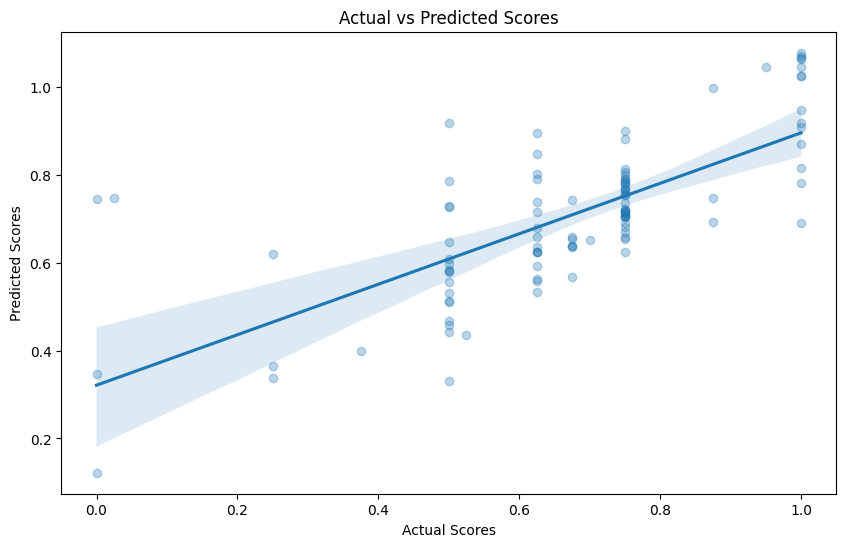

In [48]:
final_model = train_model(X_train, y_train, best_params, X_test, y_test)

results = evaluate_model(final_model, X_test, y_test, device=best_params['device'])

# Simpan model
torch.save({
    'model_state_dict': final_model.state_dict(),
    'params': best_params,
    'results': results
}, './models/final_aesindo_model.pt')

# Visualisasi optimasi
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [53]:
def analyze_results(model, X_test, y_test, df_merged_full, test_indices, device='cpu'):
    # Pastikan model di device yang benar
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        # Konversi data ke tensor dan pindahkan ke device yang sama dengan model
        test_X = torch.FloatTensor(X_test).to(device)
        
        # Lakukan prediksi
        predictions_tensor = model(test_X).squeeze()
        
        # Pindahkan tensor ke CPU sebelum konversi ke numpy
        predictions = predictions_tensor.cpu().numpy()
    
    # Ambil subset dataframe sesuai test_indices
    df_merged_test = df_merged_full.iloc[test_indices]
    
    # Buat DataFrame hasil
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': predictions,
        'Error': np.abs(y_test - predictions),
        'Kode': df_merged_test['Kode'].values,
        'Pertanyaan': df_merged_test['Pertanyaan'].values,
        'Jawaban_siswa': df_merged_test['Jawaban siswa'].values,
        'Kunci_Jawaban': df_merged_test['Kunci Jawaban'].values
    })
    
    # Tampilkan hasil analisis
    print("\nTop 5 Best Predictions:")
    print(results_df.sort_values('Error').head(5)[['Actual', 'Predicted', 'Error', 'Kode']])
    
    print("\nTop 5 Worst Predictions:")
    print(results_df.sort_values('Error', ascending=False).head(5)[['Actual', 'Predicted', 'Error', 'Kode']])
    
    # Statistik per pertanyaan
    question_stats = results_df.groupby('Kode').agg({
        'Error': ['mean', 'std'],
        'Actual': ['mean', 'std'],
        'Predicted': ['mean', 'std']
    })
    print("\nPerformance by Question:")
    print(question_stats)
    
    return results_df

In [54]:
# Tentukan device yang akan digunakan
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {device}")

# Panggil fungsi analyze_results dengan parameter device
results_df = analyze_results(
    final_model, 
    X_test, 
    y_test, 
    df_merged, 
    test_indices, 
    device=device
)

Menggunakan device: cuda

Top 5 Best Predictions:
    Actual  Predicted     Error  Kode
22   0.625   0.624210  0.000790    13
75   0.625   0.624210  0.000790    13
94   0.625   0.624210  0.000790    13
39   0.750   0.753006  0.003006     9
26   0.750   0.754416  0.004416     7

Top 5 Worst Predictions:
    Actual  Predicted     Error  Kode
36   0.000   0.744541  0.744541    12
64   0.025   0.745867  0.720867     5
55   0.500   0.918360  0.418360     3
7    0.250   0.619569  0.369569     6
73   0.000   0.347670  0.347670    11

Performance by Question:
         Error              Actual           Predicted          
          mean       std      mean       std      mean       std
Kode                                                            
1     0.060421  0.020079  0.500000  0.000000  0.531837  0.066021
2     0.095530  0.068986  1.000000  0.000000  0.987122  0.126330
3     0.286092  0.125371  0.541667  0.072169  0.715093  0.332822
4     0.089549  0.062384  0.805000  0.267161  0.7478

---
